In [1]:
import gymnasium as gym
from pogema import GridConfig
from stable_baselines3 import DQN
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Set Global parameters
MAX_EPISODE_STEPS = 30

grid_config = GridConfig(
    size=8,                                 # size of the grid map 8 = (8x8)
    density=0.3,                            # obstacle density
    num_agents=1,                           # number of agents
    obs_radius=3,                           # defines field of view
    max_episode_steps=MAX_EPISODE_STEPS,    # time horizon
    seed=None                               # set to None for random obstacles, agents and targets positions at each reset
)

env = gym.make("Pogema-v0",grid_config=grid_config)

/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -1.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


### DQN

Sources: 

* https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/dqn_sb3.ipynb
* https://github.com/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb
* https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html
    * https://stable-baselines3.readthedocs.io/en/master/common/logger.html#logger
    * https://www.tensorflow.org/tensorboard/get_started
    * https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/dqn.yml - Tuned Hyperparams for several gym envs (Hard Problem)

In [56]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=16,
    gradient_steps=8, # gradient steps to do after each rollout
    gamma=0.99, # discount factor
    exploration_fraction=0.4, 
    exploration_final_eps=0.07,
    target_update_interval=600, # update the target network afte fixed number of steps
    learning_starts=1000, # how many steps of the model to collect transitions for before learning starts
    buffer_size=10000, # size of the replay buffer
    batch_size=128, # Minibatch size for each gradient update
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=42,
    tensorboard_log="./tensorboard"
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [57]:
# Evaluate untrained agent using separate env

val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_dqn_model = DQN(
    "MlpPolicy",
    val_env,
    verbose=1,
    seed=42
)

mean_reward, std_reward = evaluate_policy(
    val_dqn_model,
    val_dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=100,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward: 0.02 +/- 0.14


In [58]:
# Train agent and save it
dqn_model.learn(total_timesteps=int(3.0e5), tb_log_name="dqn_baseline")
dqn_model.save("saved/dqn_baseline")

Logging to ./tensorboard/dqn_baseline_9
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.2     |
|    ep_rew_mean      | 0.5      |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6958     |
|    time_elapsed     | 0        |
|    total_timesteps  | 85       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22       |
|    ep_rew_mean      | 0.375    |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8295     |
|    time_elapsed     | 0        |
|    total_timesteps  | 176      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.5     |
|    ep_rew_mean      | 0.333    |
|    exploration_rate | 0.998    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 8850     |
|    time_elapsed     | 0        |
|    total_timesteps  | 270      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.4     |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.997    |
| time/               |          |
|    episodes         | 16       |
|    fps              | 9648     |
|    time_elapsed     | 0        |
|    total_timesteps  | 390      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.1     |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes       

### Load trained agent and evaluate it

In [2]:
dqn_model = DQN.load("saved/dqn_baseline")

env.reset()

mean_reward, std_reward = evaluate_policy(dqn_model, env, deterministic=True, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:0.01 +/- 0.10


### Video Recording

In [11]:
from IPython.display import SVG, display
from pogema.animation import AnimationMonitor, AnimationConfig

env = AnimationMonitor(env)

def evaluate_metrics(model, env, num_episodes=10, num_trials=100, verbose=False):
    success_count = 0
    step_array = []
    for trial in range(num_trials):
        obs, info = env.reset()

        max_step = num_episodes
        steps_taken = 0
        done = truncated = False
        while not done and max_step > 0:
            action, _ = model.predict(obs)
            next_obs, reward, done, truncated, info = env.step(action)
            if verbose:
                print(action,max_step,success_count,done)
            max_step -= 1
            steps_taken += 1
            obs = next_obs

            # Check if agent was successful in that episode.
            if done:
                success_count += 1
                step_array.append(steps_taken)
                env.save_animation(f"renders/render.svg", AnimationConfig(egocentric_idx=0))
                break
    
    # store evaluation metrics to be returned
    metrics = {}
    metrics['success_rate'] = success_count / num_trials
    metrics['step_array'] = step_array

    if len(step_array) > 0:
        ave_steps = sum(step_array)/len(step_array)
    else:
        ave_steps = None
    metrics['ave_steps'] = ave_steps

    return metrics

metrics = evaluate_metrics(dqn_model, env, num_episodes=MAX_EPISODE_STEPS, verbose=False)
print(f"Agent Success Rate: {metrics['success_rate'] * 100:.2f}%")
print(f"Steps to termination : {metrics['step_array']}")
print(f"Average steps to termination : {metrics['ave_steps']}")

Agent Success Rate: 5.00%
Steps to termination : [18, 1, 26, 1, 1]
Average steps to termination : 9.4


### Load Animation

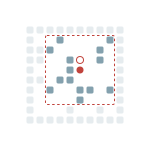

In [65]:
display(SVG('renders/render.svg'))

### Tensorboard

In [66]:
%tensorboard --logdir tensorboard/dqn_baseline_9

Reusing TensorBoard on port 6010 (pid 57467), started 0:00:31 ago. (Use '!kill 57467' to kill it.)

### Evaluation metrics: Mann-Whitney U test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

In [9]:
from scipy.stats import mannwhitneyu

In [24]:
# sample data of completion runs
grp1 = [19, 22, 16, 29, 24]
grp2 = [20, 11, 17, 12, 27]

In [25]:
mannwhitneyu(grp1, grp2, alternative='two-sided')

MannwhitneyuResult(statistic=18.0, pvalue=0.30952380952380953)